# Run  prism_800m_normals, ppt_ratio_parameters, and temp_adjust_parameters

#### Daily climate for each grid cell/HRU is required for GSFLOW. A good approach for generating daily climate for each cell/HRU in the model is to rely on climate stations for the daily values (Tmin, Tmax, and PPT). Monthly average spatial adjustment factors are then used to distribute the climate station data to all cells/HRUs. For temperature, either the Temp_1sta or Temp_lapse module is used. For Temp_1sta, temperature adjustment factors by month and cell/HRU are calculated using the monthly PRISM 30-year normals and reprepsent the effects of altitude, slope, and aspect on temperature; for this case, the paramers Tmax_lapse and Tmin_lapse should be set to zero. The PRMS module Temp_lapse uses two climate stations located at different altitudes to represent the effects of altitude on temperature, and Tmax_adj and Tmin_adj are used to represent the effects of slope and aspect on temperature. The latter approach is preferred if there is a low and high altitude station within or near the subbasin. The default approach for the prism_parameters.py script is Temp_1sta, and this can be changed to Temp_lapse in the configuration (.ini) file. Similarly, the Precip_1sta module is default and spatial adjustment factors are calculated using the monthly PRISM 30-year normals.

#### PRMS can read daily climate grids directly, and you may be asking why the dialy PRISM or other gridded climate data is not input directly to the model. The reason is that for basin scale models, the daily climate grids take up huge amounts of disc space, and slow the model significantly to read these data sets for each model time step.

In [1]:
%matplotlib inline
import sys, os
import matplotlib.pyplot as plt
import arcpy
import geopandas
import matplotlib.image as mpimg
import ConfigParser
from matplotlib import cm
from arcpy import env
python_exe = sys.executable

In [2]:
# Set folder locations
arc_gsflow_folder=r"..\scripts"
config_file_folder=r"..\examples\sagehen"

#### GsflowArcpy uses a configuration file to set variables required by the scripts. Below the configuration file template is read, and default values are changed and written to the configuration file (".INI") read by GsflowArcpy.

In [3]:
# Load GsflowArcpy configuration file
Config = ConfigParser.ConfigParser()
Config.read("..\examples\sagehen\sagehen_parameters_orig.ini")

['..\\examples\\sagehen\\sagehen_parameters_orig.ini']

#### Values set below are required for running the prism_800m_normals, ppt_ratio_parameters, and temp_adjust_parameters scripts.

In [4]:
# Set problem specific variable values for script
prism_folder = r"..\examples\sagehen\prism"
# Resampling method: BILINEAR, CUBIC, NEAREST
prism_projection_method = "BILINEAR"
# Output projected cellsize, not PRISM input cellsize
prism_cellsize = 90
# Recalculate JH coefficient with PRISM temperature values
calc_prism_jh_coef_flag = True
# PPT Ratios
set_ppt_zones_flag = False
ppt_obs_units = "mm"
# If set_ppt_zones_flag is false, mean monthly ppt must be set manually
ppt_obs_list = "140, 133, 119, 54, 38, 18, 11, 15, 22, 52, 103, 142"
# If a valid HRU_ID is set, PPT ratios will be adjusted to be 1 at that HRU_ID
ppt_hru_id = 0
# If set_ppt_zones_flag is True, mean monthly ppt will be read from a PPT zones shapefile
# PPT ratios will be adjusted to be 1 at each zone HRU_ID (set in ppt_hru_id_field)
ppt_zone_path = r"..\examples\sagehen\shapefiles\ppt_zones.shp"
ppt_zone_field = "PPT_ZONE"
ppt_hru_id_field = "PPT_HRU_ID"
ppt_obs_field_format = "PPT_{:02d}"

# Temperature Calculation (ZONES, LAPSE, 1STA)
temperature_calc_method = "1STA"
temp_obs_units = "F"

# If using 1STA, mean monthly temperature must be set manually
tmax_obs_list = "39.99, 41.97, 47.44, 53.26, 61.89, 71.02, 79.07, 78.43, 71.56, 60.31, 46.64, 39.05"
tmin_obs_list = "14.24, 15.82, 20.26, 24.29, 29.38, 33.50, 37.19, 36.32, 31.63, 26.08, 20.48, 14.99"
# If a valid non-zero HRU_ID is set, temperature ratios will be adjusted to be 1 at that HRU_ID
temp_hru_id = "0"

# If using ZONES, mean monthly tmax/tmin will be read from a 
#   temperature zones shapefile.
# Temperature ratios will be adjusted to be 1 at each zone HRU_ID 
#   (set in temp_hru_id_field)
temp_zone_path = r"..\examples\sagehen\shapefiles\temp_zones.shp"
temp_zone_field = "TEMP_ZONE"
temp_hru_id_field = "TMP_HRU_ID"
tmax_obs_field_format = "TMAX_{:02d}"
tmin_obs_field_format = "TMIN_{:02d}"

In [5]:
# Set and write out modified values to configuration file
cfgfile = open("..\examples\sagehen\sagehen_parameters.ini",'w')
Config.set('INPUTS','prism_folder',prism_folder)
Config.set('INPUTS','prism_projection_method',prism_projection_method)
Config.set('INPUTS','set_ppt_zones_flag',set_ppt_zones_flag)
Config.set('INPUTS','calc_prism_jh_coef_flag',calc_prism_jh_coef_flag)
Config.set('INPUTS','ppt_obs_units',ppt_obs_units)
Config.set('INPUTS','ppt_obs_list',ppt_obs_list)
Config.set('INPUTS','ppt_hru_id',ppt_hru_id)
Config.set('INPUTS','ppt_zone_path',ppt_zone_path)
Config.set('INPUTS','ppt_zone_field',ppt_zone_field)
Config.set('INPUTS','ppt_hru_id_field',ppt_hru_id_field)
Config.set('INPUTS','ppt_obs_field_format',ppt_obs_field_format)

Config.set('INPUTS','temperature_calc_method',temperature_calc_method)
Config.set('INPUTS','temp_obs_units',temp_obs_units)
Config.set('INPUTS','tmax_obs_list',tmax_obs_list)
Config.set('INPUTS','tmin_obs_list',tmin_obs_list)
Config.set('INPUTS','temp_hru_id',temp_hru_id)
Config.set('INPUTS','temp_zone_path',temp_zone_path)
Config.set('INPUTS','temp_zone_field',temp_zone_field)
Config.set('INPUTS','temp_hru_id_field',temp_hru_id_field)
Config.set('INPUTS','tmax_obs_field_format',tmax_obs_field_format)
Config.set('INPUTS','tmin_obs_field_format',tmin_obs_field_format)

Config.write(cfgfile)
cfgfile.close()

#### Run the GsflowArpcy script prism_800m_normals.

In [6]:
# Set and run prism_800m_normals script
script = r"prism_800m_normals.py"
argument = r" -i ..\examples\sagehen\sagehen_parameters.ini"
cmd=python_exe + " " + os.path.join(arc_gsflow_folder,script)
cmd = cmd + argument
os.system(cmd)

0

#### Run the GsflowArpcy script ppt_ratio_parameters.

In [7]:
# Set and run ppt_ratio_parameters script
script = r"ppt_ratio_parameters.py"
argument = r" -i ..\examples\sagehen\sagehen_parameters.ini"
cmd=python_exe + " " + os.path.join(arc_gsflow_folder,script)
cmd = cmd + argument
os.system(cmd)

0

#### Run the GsflowArpcy script temp_adjust_parameters.

In [8]:
# Set and run temp_adj_parameters script
script = r"temp_adjust_parameters.py"
argument = r" -i ..\examples\sagehen\sagehen_parameters.ini"
cmd=python_exe + " " + os.path.join(arc_gsflow_folder,script)
cmd = cmd + argument
os.system(cmd)

0

#### Plot Tmax_adj for January

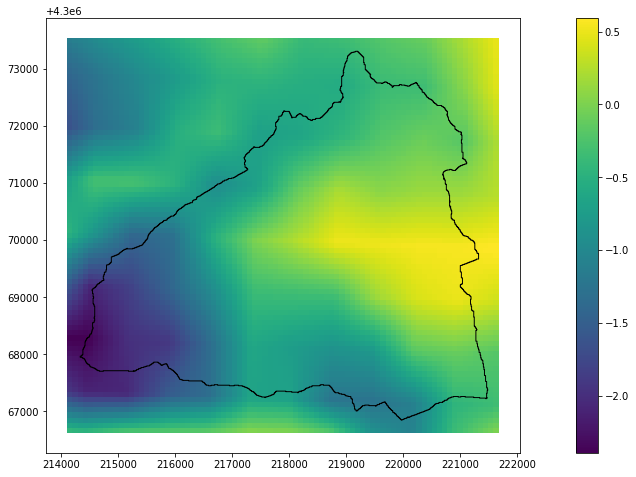

In [9]:
# Plot PRMS parameter Tmax_adj
fig, ax = plt.subplots(figsize=(20,8))
fn1=r"..\examples\sagehen\shapefiles\watershed_proj.shp"
fn2=r"..\examples\sagehen\hru_params\hru_params.shp"
boundary=geopandas.read_file(fn1)
hru_params=geopandas.read_file(fn2)
hru_params.plot(column="TMX_ADJ_01",ax=ax,legend=True)
boundary.plot(ax=ax,color='none', edgecolor='black', linewidth=1.0)
plt.show()

## Class Exercise:


#### Plot the precipitation adjustment factor for January ("PPT_RT_01"). Note the scripts use the same values for rain_adj and snow_adj. How much of an affect does altitude have on precipitation amount?